# Superimpose Notebook
A notebook to demonstrate the superimposing of the device mask on top of the wafer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import cairosvg
from PIL import Image
from io import BytesIO
import cv2

In [2]:
# append parent directory, dumb hack to make package importing work
sys.path.append(os.path.dirname(os.getcwd()))
from frgtrainview.analysis.crop import crop_pl

In [16]:
crop_pl??

Signature: crop_pl(img, output_shape=None)
Source:   
def crop_pl(img, output_shape=None):
    """Crops a PL image so that only the sample is visible.

    Args:
        img (ndarray): a PL image.
        output_shape (Tuple[int, int]): desired size for the output image.
    
    Returns:
        ndarray: a cropped PL image containing only the sample, with shape==output_shape if given.
        Otherwise, the shape is the size of the bounding box that contains the sample in the original image img.
        ndarray: an array of length 4 representing the corners of the bounding box the sample is contained within on the original image img.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.inRange(gray, 250, 256) # threshold on white, the border of sample

    # use houghline transform to clean up and create border
    minLineLength = thresh.shape[0]*0.03
    maxLineGap = 200
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGa

In [3]:
from frgpascal.analysis.processing import load_all
from natsort import index_natsorted

def load_all_sorted(chardir):
	metricdf, rawdf = load_all(
		chardir,
		t_kwargs=dict(
			wlmin=700,
			wlmax=900
		)
	)
	rawdf= rawdf.sort_values(
   		by='name',
   		key=lambda x: np.argsort(index_natsorted(rawdf['name']))
    )
	rawdf = rawdf.reset_index(drop=True)


	metricdf= metricdf.sort_values(
    	by='name',
    	key=lambda x: np.argsort(index_natsorted(metricdf['name']))
    )
	metricdf = metricdf.reset_index(drop=True)
	return metricdf, rawdf

In [9]:
# load the images
chardir = '../data/output/20221025_B12-char/Characterization'
_, rawdf = load_all_sorted(chardir)

Loading data:   0%|          | 0/32 [00:00<?, ?sample/s]/home/kcw/miniconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:105: RuntimeWarning: invalid value encountered in log10
  a = -np.log10(t)
Loading data:   9%|▉         | 3/32 [00:01<00:17,  1.63sample/s]/home/kcw/miniconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:105: RuntimeWarning: divide by zero encountered in log10
  a = -np.log10(t)
Loading data: 100%|██████████| 32/32 [00:17<00:00,  1.85sample/s]


In [17]:
temp = rawdf['plimg_0'].apply(lambda img: crop_pl(np.uint8(img * 255), output_shape=(256,256)))
pl = pd.DataFrame([[img, coords] for img, coords in temp.values], columns=['crop', 'coords'])
pl = pl.join(rawdf['plimg_0'])

In [11]:
pl.head(3)

,crop,coords,plimg_0
0,"[[[0.9892578, 0.703125, 0.0], [0.9069824, 0.68...","[[0.0, 0.0], [1439.0, 0.0], [1439.0, 1079.0], ...","[[[0.9892578, 0.703125, 0.0], [0.9980469, 0.67..."
1,"[[[0.9785156, 0.6972656, 0.14941406], [0.88281...","[[0.0, 0.0], [1439.0, 0.0], [1439.0, 1079.0], ...","[[[0.9785156, 0.6972656, 0.14941406], [0.99804..."
2,"[[[0.97558594, 0.69140625, 0.13085938], [0.858...","[[0.0, 0.0], [1439.0, 0.0], [1439.0, 1079.0], ...","[[[0.97558594, 0.69140625, 0.13085938], [0.998..."


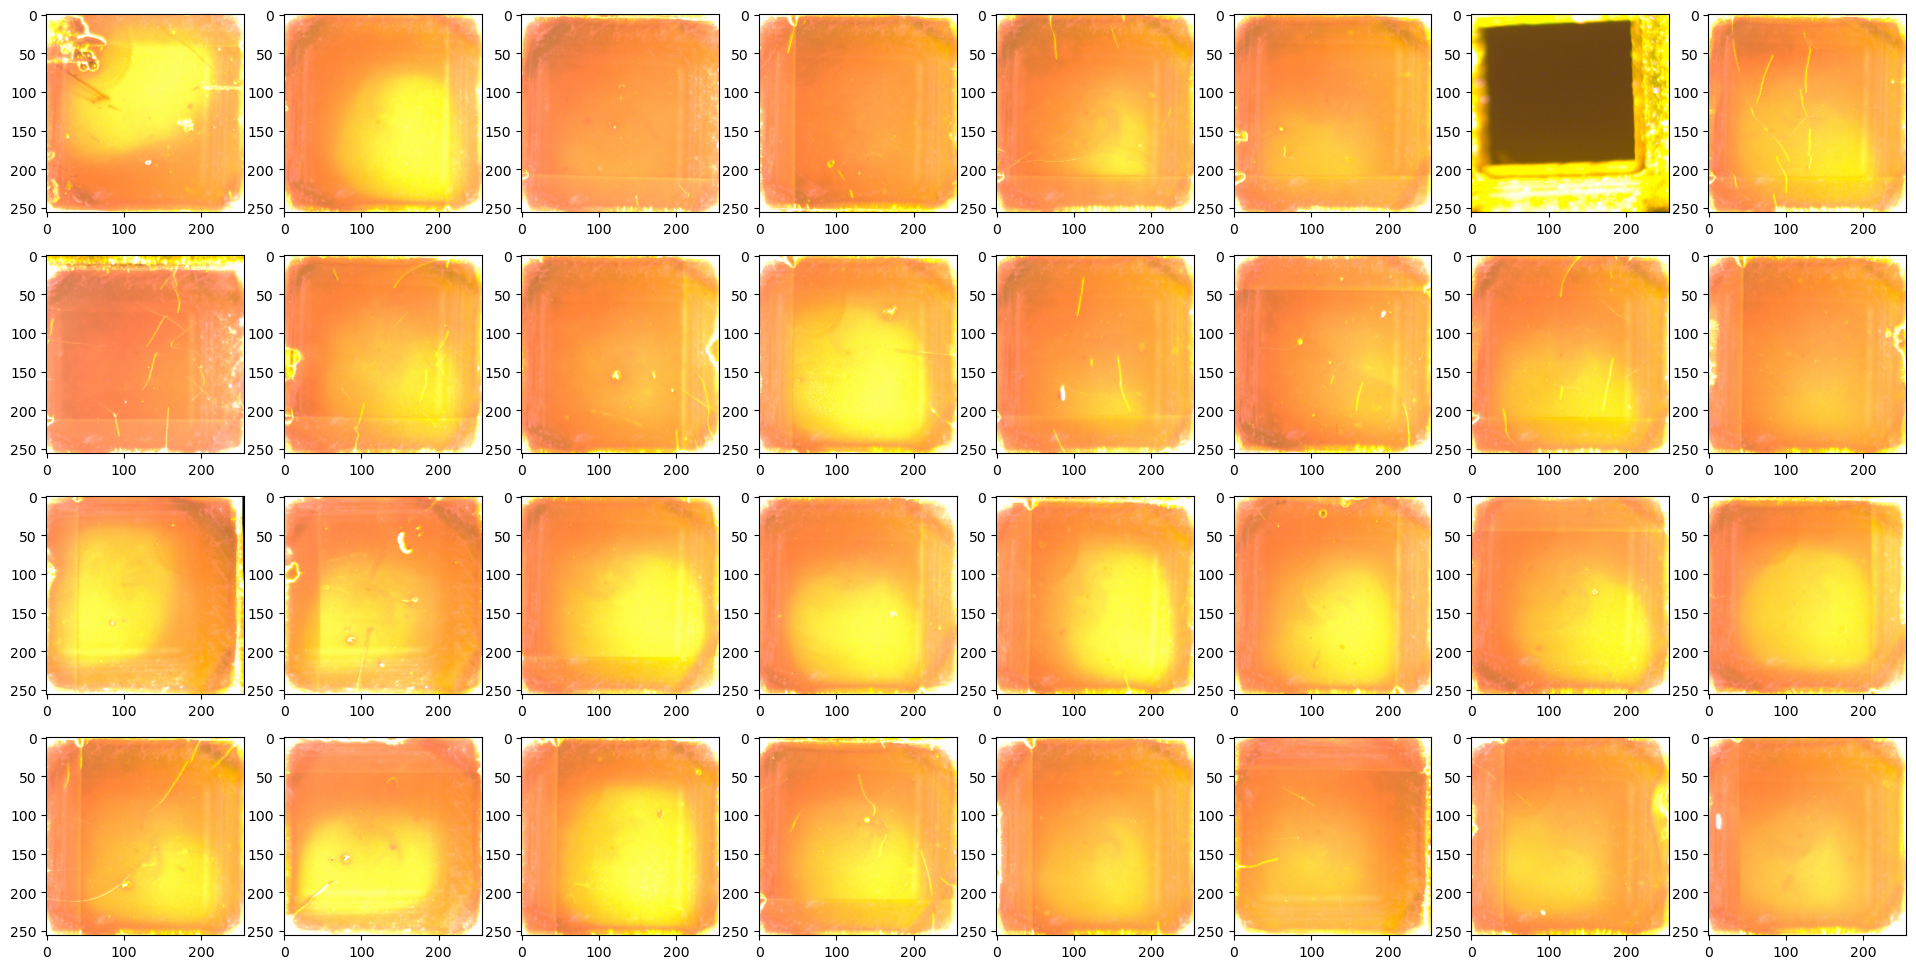

In [18]:
# view whole batch of pl images

# now plot
blank = pl.iloc[0]*0

vert = 4
horiz = 8
embiggen = 3
item = 0

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen), constrained_layout=False)

for k in range(horiz):
    for n in range(vert):
        try:
            img = pl['crop'].iloc[item]
            ax[n,k].imshow(img)
            # plt.text(0.01, 1, s = f'{rawdf["sample_num"].iloc[item]}', horizontalalignment='left', verticalalignment='top', transform=ax[n,k].transAxes, color='Red', weight='bold', backgroundcolor='White')
            
        except:
            ax[n,k].imshow(blank)
            
        
        item += 1

[[ 310.  154.]
 [1177.  124.]
 [1208. 1000.]
 [ 340. 1030.]]


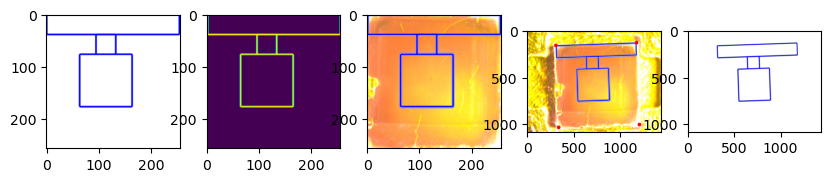

In [132]:
# superimpose the device mask on top of the wafer
# TODO: orient the device mask to fit with scribe

i=5
img = pl['crop'].iloc[i].copy()
orig = pl['plimg_0'].iloc[i].copy()

with open('../frgtrainview/analysis/devicemask_plain.svg', 'r') as f:
    img_png = cairosvg.svg2png(file_obj=f, dpi=1000)
mask_img = np.asarray(Image.open(BytesIO(img_png)))
mask_img = cv2.resize(mask_img, img.shape[:2])

# recolor the mask
alpha = mask_img[:,:,3]
hsv = cv2.cvtColor(mask_img[:,:,0:3], cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv)
s[alpha > 0] = 255
v[alpha > 0] = 255
hnew = np.uint8(np.mod(h + 120, 180))
hsv = cv2.merge([hnew, s, v])
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
mask_img = np.concatenate((rgb, np.expand_dims(alpha, axis=2)), axis=2)

# draw mask on top of cropped image
img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
img[alpha > 0] = mask_img[alpha>0]

# now superimpose mask on top of original image
input_shape = mask_img.shape
input_pts = np.array([
    [0,0],
    [input_shape[0], 0],
    [input_shape[0], input_shape[1]],
    [0, input_shape[1]],
    ], np.float32)
M = cv2.getPerspectiveTransform(input_pts, pl['coords'].iloc[i]) # needs float32 arrays
out = cv2.warpPerspective(mask_img, M, orig.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

orig = np.uint8(orig * 255)
orig = cv2.cvtColor(orig, cv2.COLOR_RGB2RGBA)
orig[out[:,:,3] > 0] = out[out[:,:,3] > 0]

# also draw bounding box corners
for c in pl['coords'].iloc[i]:
    cv2.circle(orig, np.int0(c), 20, color=(255,0,0,255), thickness=-1)

fig, ax = plt.subplots(1, 5, figsize=(10,8))

ax[0].imshow(mask_img) # original mask
ax[1].imshow(mask_img[:,:,3]) # alpha channel of mask
ax[2].imshow(img) # mask superimposed on cropped
ax[3].imshow(orig) # mask superimposed on original
ax[4].imshow(out) # mask perspective warped to original
print(pl['coords'].iloc[i])